# Introduction
In my previous notebook `3. Dimensionality reduction with PCA` I implemented PCA using numpy and scipy components. I also encoded the emails in the spamassassin corpus as one hot vectors with the vectors representing the precense of a specific word in the email subject or body.

I chose to discard any word that was not present in 10 emails or more. The reason for this was to avoid running our of memory when doing PCA. This reduced the number of unique words fro ~100,000 to ~7,000. 
I performed PCA and found that 1,500 principal components hold ~94% of the explained variance contained in the ~7,000 word vectors.

In this notebook I will divide the data into a test and training set, and see what accuraccy I can get with some basic machinelearning approaches. (I have introduced a bias by not spliting the data into a training and test set before choosing which words get a word vector and performing PCA. I should have set aside a test set from the very start had this been a real project.)

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# Split the data into training and test set

In [5]:
data = pd.read_csv('data.csv', encoding='latin')
word_vectors = np.load('onehot_data_reduced.npy')

In [8]:
label_map = {
    'spam' : 'spam', 
    'spam_2' : 'spam', 
    'easy_ham' : 'ham', 
    'easy_ham_2' : 'ham', 
    'hard_ham' : 'ham'
}
labels = data['dataset'].apply(lambda x: label_map[x])

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

In [22]:
split = StratifiedShuffleSplit(n_splits=1, test_size=.3, random_state=0)

In [40]:
# Using data set as stratify parameter to makse sure we get proportional amount of entries from all data sets in both the test and training set
splits  = list(split.split(np.zeros(len(word_vectors)), data['dataset']))[0]

In [38]:
train_ids = splits[0]
test_ids = splits[1]

In [61]:
X_train = word_vectors[train_ids]
Y_train = labels[train_ids]
datasets_train = data['dataset'][train_ids]

In [60]:
X_test = word_vectors[test_ids]
Y_test = labels[test_ids]
datasets_test = data['dataset'][test_ids]

Let's quickly illustrate the effect of doing a stratified split.

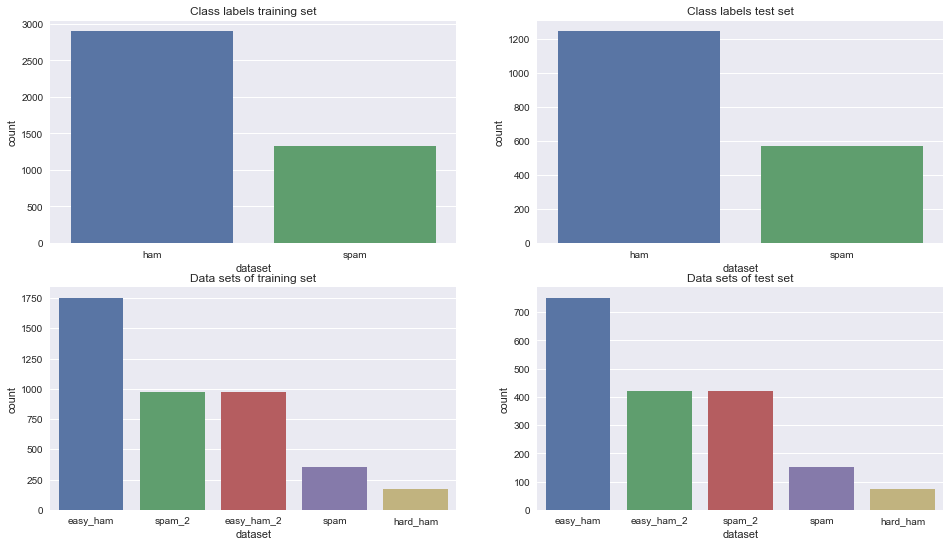

In [62]:
f, ax = plt.subplots(2, 2, figsize=(16,9))
# Plot the class labels
ax[0][0].set_title('Class labels training set')
sns.countplot(Y_train, ax=ax[0][0])
ax[0][1].set_title('Class labels test set')
sns.countplot(Y_test, ax=ax[0][1])

# Plot the
ax[1][0].set_title('Data sets of training set')
sns.countplot(datasets_train, ax=ax[1][0], order=datasets_train.value_counts().index)
ax[1][1].set_title('Data sets of test set')
sns.countplot(datasets_test, ax=ax[1][1], order=datasets_test.value_counts().index)

Nice! The test and training set have the same distribution of both class labels and source data sets.

# KNN Classification

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict

In [80]:
knn = KNeighborsClassifier(n_neighbors=3)

In [81]:
cross_val_score(X=X_train, y=Y_train, cv=3, estimator=knn)

array([ 0.94326241,  0.92193045,  0.90844571])

Looks like pretty poor performance. Of course I should test some other hyper parameters to be sure.

# Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
log_reg = LogisticRegression()

In [79]:
cross_val_score(X=X_train, y=Y_train, cv=3, estimator=log_reg)

array([ 0.98368794,  0.98367637,  0.98012775])

Much better results than KNN right of the bat. Let's see what our confusin matrix looks like.

In [82]:
predictions = cross_val_predict(X=X_train, y=Y_train, cv=3, estimator=log_reg)

In [83]:
from sklearn.metrics import confusion_matrix

In [90]:
confusion_matrix(y_pred=predictions, y_true=Y_train, labels=['ham', 'spam'])

array([[2854,   47],
       [  27, 1300]], dtype=int64)

27 ham emails classified as spam and 47 spam mails classified as ham. In my opinion it's better that a spam classifier lets' a few extra spam mails through but never discard real email. So ideally there should be 0 ham emails classified as spam.

Let's see if we can adress this, even if it's at the expense of accurracy.